In [2]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wishart
from numpy.linalg import inv
import timeit
import time

 
$p \sim \textrm{Dirichlet}(\alpha /K)$  
$c \sim \textrm{Discrete}(p)$  
$\mu_{x_c} \sim \textrm{N}\big(\mu_{x_0}, \sum_{x_0}\big)$   
$\Lambda_{x_c} \sim \textrm{W}(K+1, \Lambda_{x_0})$   
$X \sim \textrm{N}(\mu_{x_c}, \Lambda_{x_c}^{-1}) $

Priors  
$\frac{1}{2 \alpha} \sim \textrm{Gamma}(1,1)$  
$\mu_{x_0} \sim \textrm{N}\bigg(\left [\begin{array}{c} 0 \\ 0 \end{array}\right], \left[\begin{array}{cc}100 & 0\\0 & 100\end{array} \right] \bigg)$  
$\Lambda_{x_0} \sim \textrm{W}\bigg(K, \left[\begin{array}{cc}0.001 & 0\\0 & 0.001\end{array} \right]\bigg)$ 


In [3]:
###########################
# priors
# 1/(2*alpha) ~ Gamma(1,1)
# mu_cx0 ~ N([0,0],[[100, 0],[0, 100]])
# cov_x0^-1 ~ Wishart(K, [[0.001,0],[0, 0.001]])
###########################
# prp ~ Dir(alpha/K)
# c ~ Discrete(prp)
# mu_xc ~ N(mu_xc0, cov_x0)
# prec_xc ~ Wishart(K+1, prec_xc0)
# X ~ N(mu_xc, prec_xc)
#########################

def gen_latent_parameters(alpha, K, mux0, convx0, precx0, N):
    prp = np.random.dirichlet(np.repeat(alpha / K, K), 1)[0] # proportional class
    c = np.random.choice(K, N, p=prp) # membership
    mux = np.random.multivariate_normal(mux0, covx0, K) # centers of classes
    precx = wishart.rvs(K + 1, precx0, K) # precisions of classes    
    return prp,c,mux,precx
    
def gen_mixture_gaussian(alpha, K, mux0,covx0,precx0, N):
    prp,c,mux,precx = gen_latent_parameters(alpha, K, mux0,covx0,precx0, N)
    inv_precx = inv(precx)
    x_gen = np.repeat(np.nan, 2*N).reshape([-1,2])
    for i in range(K):
        loc = c==i
        x_gen[loc] = np.random.multivariate_normal(mux[i], inv_precx[i], loc.sum())
    return (prp,c,mux,precx), x_gen

In [4]:
class SSTAT(object):
    def __init__(self, data, ndiv, margin_pct=0.1):
        self.data = data
        self.ndiv = np.array(ndiv)
        self.margin_pct = margin_pct
        self._create_grids()

        self.sstat_data = self._count_occurrence(data)


    def _cal_margin(self, x, upper, x_range):
        return x+self.margin_pct*upper*x_range

    def _create_grids(self):
        rec = [self.data[:, 0].min(),
               self.data[:, 1].min(),
               self.data[:, 0].max(),
               self.data[:, 1].max()]  # LeftLowerRightUpper
        xy_range = [rec[2]-rec[0], rec[3]-rec[1]]
        rec[:2] = [self._cal_margin(x, -1, r) for x,r in zip(rec[:2],xy_range)]
        rec[2:] = [self._cal_margin(x, 1, r) for x,r in zip(rec[2:],xy_range)]

        self.grids = []
        self.grids.append(np.linspace(rec[0], rec[2], self.ndiv[0]+1))
        self.grids.append(np.linspace(rec[1], rec[3], self.ndiv[1]+1))

    def _count_occurrence(self, new_data):
        cnt_mat = np.zeros(self.ndiv)
        for i, xp1, xp2 in zip(range(self.ndiv[0]), self.grids[0][:-1], self.grids[0][1:]):
            xpos = (new_data[:,0]>xp1) & (new_data[:,0]<=xp2)
            for j, yp1, yp2 in zip(range(self.ndiv[1]), self.grids[1][:-1], self.grids[1][1:]):
                ypos = (new_data[:,1]>yp1) & (new_data[:,1]<=yp2)
                cnt_mat[i,j] = len(np.where(xpos & ypos)[0])
        return cnt_mat

    def compute_sstat(self, new_data):
        """
        compute summary statistics
        returns avg nbr of counts difference
        
        """
        return np.abs(self._count_occurrence(new_data) - self.sstat_data).sum() / np.product(self.ndiv)



In [5]:
def abc_rej_v01(priors, gen_func, sstat_func, ns=100, eps=5, ax=None, maxiter=100000):
    param_lst = []
    time_lst = []
    t0 = timeit.default_timer()    
    plt.ion()
    citer = 0
    while len(param_lst)<ns and citer<maxiter:
        params_cand, data_gen = gen_func(*priors)
        ss_dif = sstat_func(data_gen)
        
        if ss_dif<eps:
            t1 = timeit.default_timer()
            time_lst.append(t1-t0)
            t0 = t1
            param_lst.append(params_cand)
            print('%i : %f secs : %f' % (len(param_lst), time_lst[-1], ss_dif))
            if ax is not None:
                ax.cla()
                ax.scatter(data_gen[:,0], data_gen[:,1], c=params_cand[1], alpha=0.1)
                #display.display(plt.gcf())
                #display.clear_output(wait=True)
                ax.figure.canvas.draw()                
                time.sleep(1)
            maxiter += 1
            
    return param_lst, time_lst

<IPython.core.display.Javascript object>


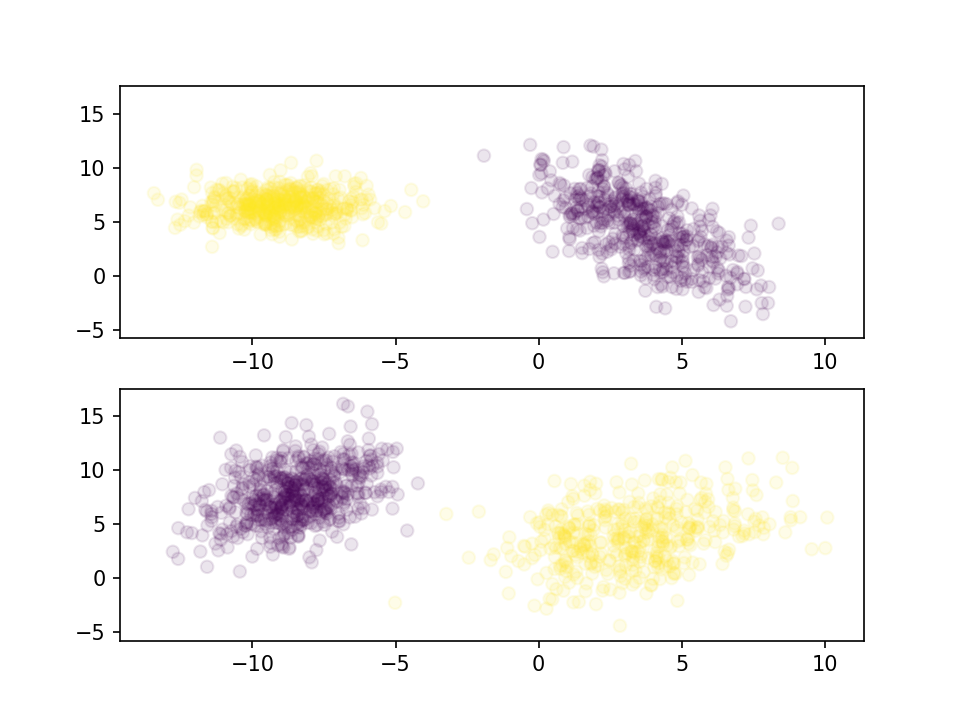

In [6]:
N = 1000
K = 2
alpha = 5.0
mux0 = [0, 0]
covx0 = [[100,0],[0,100]]
precx0 = [[0.1, 0], [0, 0.1]]

np.random.seed(90)
priors = [alpha, K, mux0, covx0, precx0, N]
gen_func = gen_mixture_gaussian
params, data = gen_func(*priors) # target data

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.scatter(x=data[:,0], y=data[:,1], c=params[1], alpha=0.1)
ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)

In [ ]:
sstat = SSTAT(data, (5,5))
xx = abc_rej_v01(priors, gen_func, sstat_func = sstat.compute_sstat, ns=20, eps=20, ax=ax2)

1 : 72.938487 secs : 17.120000
2 : 3.261574 secs : 18.720000
3 : 52.792988 secs : 19.920000
4 : 140.282191 secs : 18.560000
5 : 91.037301 secs : 18.120000
